# Design patterns

Now we have completed a relatively simple but fully functional pipeline, let's revisit some design patterns that were used in your pipeline and will commonly occur in the future pipeline you would design.

As always, let's start by importing DataJoint package. Also, import all the tables by importing them from the `workshop.session3` module.

In [1]:
import datajoint as dj
from workshop.session3 import schema, Mouse, Session, Neuron, ActivityStatistics, SpikeDetectionParam, Spikes

Connecting TaliahMu@workshop-db.datajoint.io:3306


We are also going to take a look at another pre-defined pipeline, defined in the `workshop.calcium` module.

In [2]:
import workshop.calcium as ca

We are going to learn a lot more about this pipeline in a session tomorrow, but for now, we are going to take a look at the ERD and compare it to our pipeline.

## Experimental subjects as the root of your schema

Let's take a look at our pipeline's ERD again

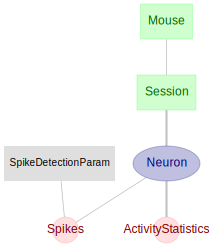

In [3]:
dj.ERD(schema)

Let's also plot the ERD for the `ca` module.

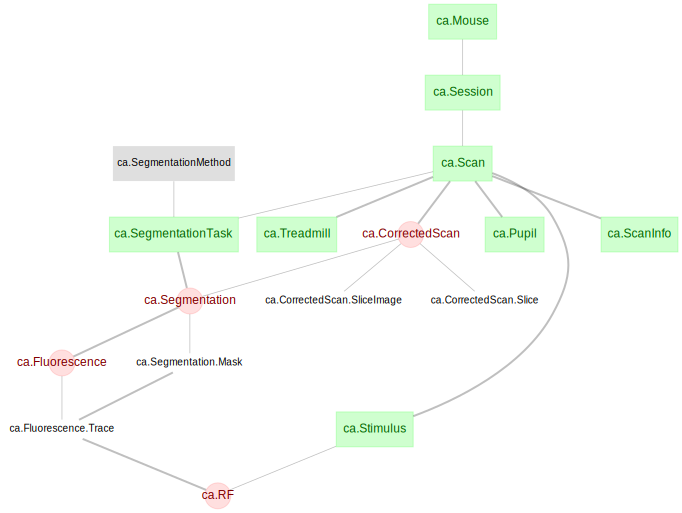

In [4]:
dj.ERD(ca)

Notice that while the calcium pipeline is quite a bit more complex than ours, both piplines start with a `Mouse` table at the very top!

When designing data pipelines, we tend to see this pattern of **a pipeline starting with the experimental subject** over and over. If you think about it, this makes sense as our experiments pretty much ultimately depends on the experimental subjects, and the identity of our experimental subjects typically do not depend on other information.

## One-to-many vs one-to-one relationships

Let's compare the relationships seen between:
1. `Mouse` table and `Session` table, to
2. `Session` table and `Neuron` table

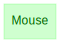

In [5]:
dj.ERD(Mouse)

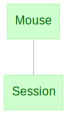

In [6]:
dj.ERD(Mouse) + Session

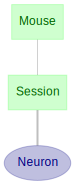

In [7]:
dj.ERD(Mouse) + 2

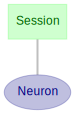

In [8]:
#one to one relationship but to make it one to many 
#just add another table that it's dependent on??
dj.ERD(Session) + Neuron

In [12]:
Neuron.heading

# 
mouse_id             : int                          # Unique animal ID
session_date         : date                         # date
---
activity             : longblob                     # electric activity of the neuron

In [13]:
Neuron.describe()

# 
-> Session
---
activity             : longblob                     # electric activity of the neuron



'# \n-> Session\n---\nactivity             : longblob                     # electric activity of the neuron\n'

Notice that `Session` and `Neuron` tables are connected by a thicker line which indicates that the parent table (`Session`) fully identifies the child table (`Neuron`). We call this relationship **one-to-one** - for a single session there exists at most one neuron.

In contrast, `Mouse` and `Session` tables are connected by a thin line, indicating that `Mouse` alone does **not** uniquely identify an entry in `Session` - in other words, `Session` table has one or more additional primary key attributes that are needed together with mouse identity to uniquely identify a single session.

Having designed the table, we know that you need to know both the **mouse** and the **session_date** to uniquely identify a single session. Because of this, you can have more than one session for a mouse as long as they differ in the `session_date`. As you might have guessed, we call this kind of relationship **one-to-many** - for a single mouse, we may have any number of sessions. 

Knowing this, can you identify which relationships in the `calcium` pipelines are **one-to-one** vs **one-to-many**?

## Lookup tables to hold parameters for analysis/processing

In our pipeline, we have defined `SpikeDetectionParam` as a `Lookup` table to hold parameters for the spike detection.

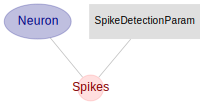

In [14]:
dj.ERD(SpikeDetectionParam) + Neuron + Spikes

Whenever you define a computed table (such as `Spikes`, detecting and storing spikes), you will often see that the computation depends on one or more **parameters** that can strongly influence the result of your computations - and therefore the resulting entries in the computed table.

Example of such paramters include:
* spike detection threshold during spike detection
* spike detection method
* segmentation method for fluorescent image segmentation
* ridge regression regularizer weight

If you implement your `Computed` table's `make` using a fixed value of a parameter, you will have to delete the table entry and recompute everytime you want to try out new value for the parameter. Not only is this cumbersome, but it makes it difficult for you to do side-by-side comparisons of the results based on different parameter values.

It is therefore recommended for you to "break-out" the parameters for your computation into a separate `Lookup` table and have your computed table depend on it. This allows you to compute and store the computation results **for every possible combination of data and parameter**, just like we saw it for the case of `Spikes` table!

## Breaking tables apart

Early in your data pipeline design experience, you may have an urge to define *a bit table* that contains all information in one place. For example, you might want to define a table that effectively combines our `Mouse`, `Session` and `Neuron` table! Your table may look something like:

| mouse_id | dob        | sex     | session_date | experiment_setup | experimenter    | activity |
|:--------:|------------|---------|--------------|------------------|-----------------|----------|
| 0        | 2017-03-01 | M       | 2017-05-15   | 0                | Edgar Y. Walker | =BLOB=   |
| 0        | 2017-03-01 | M       | 2017-05-19   | 0                | Edgar Y. Walker | =BLOB=   |
| 1        | 2016-11-19 | M       |              |                  |                 |          |
| 2        | 2016-11-20 | unknown |              |                  |                 |          |
| 5        | 2016-12-15 | F       | 2017-01-05   | 1                | Fabian Sinz     | =BLOB=   |
| 10       | 2017-01-01 | F       |              |                  |                 |          |
| 11       | 2017-01-03 | F       |              |                  |                 |          |
| 100      | 2017-05-12 | F       | 2017-05-25   | 100              | Jacob Reimer    | =BLOB=   |
| 100      | 2017-05-12 | F       | 2017-06-01   | 1                | Jacob Reimer    | =BLOB=   |

While you may first think that this is better because **everything is present in one place**, you will quickly notice that this kind of table harbors many issues:

1. notice that you now have columns with a lot of duplication. For example, the `dob` and `sex` columns gets repeated for every recording session you perform on that animal.
2. some rows now have "empty" columns (`session_date`, etc) to indicate that the animal does not have a session recorded yet.
3. It is no longer clear **what exactly each row represents**. Not every row corresponds to a valid experiment session because some animals lack session. Nor is the table a good listing of the animals due to duplication.

Hopefully you can see that working with tables like above ends up requiring additional parsing to be done before you can get to the information you actually want - and that's not fun!

Also note that this kind of tables necessitates you to think in terms of individual attributes (columns), and you can easily get lost in the mess.

One key design principle for DataJoint data pipeline is to make sure that each table concretely represent a category of "things" of "entities". 

This allows you to identify each *row* of a table as representing an well-defined entity - such as mouse, session, neuron, or spikes. When you form queries, you also don't have to think about the columns much but think much more in terms of the entities you work with - something you do naturally already!

### Joining tables

In the first session, we saw that we can actually combine multiple tables into one using the **join** `*` operator.

In [15]:
Mouse * Session * Neuron

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name,activity electric activity of the neuron
0,2017-05-15,2017-03-01,M,0,Edgar Y. Walker,=BLOB=
0,2017-05-19,2017-03-01,M,0,Edgar Y. Walker,=BLOB=
5,2017-01-05,2016-12-25,F,1,Fabian Sinz,=BLOB=
100,2017-05-25,2017-05-12,F,100,Jacob Reimer,=BLOB=
100,2017-06-01,2017-05-12,F,1,Jacob Reimer,=BLOB=


You might wonder what is different between this joined table and the big table above. If you look carefully, the result of joins do not contain "missing" entries. For example, `mouse_id = 1` is no where to be found.

The best way to understand this is to see the result of the join operations are representing **all valid combinations** of entities. Any single entry in the resulting table represents a valid combination of mouse, session and neuron - and there is no missing information. Also note that each such combination is fully identifiable by the combination of the primary key attributes.

# Query challenges

Now you are armed with a deeper appreciation of the pipeline you have already created, let's learn to dissect and explore your pipelines by learning to build queries to answer questions. We will start simple, and build up in the query complexity!

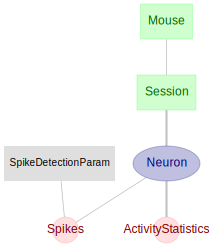

In [16]:
dj.ERD(schema)

### Which spike set had spike counts of 25 or more?

In [39]:
# ENTER YOUR CODE!
Spikes & 'count>=25'

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-15,1,=BLOB=,27
100,2017-05-25,0,=BLOB=,41
100,2017-05-25,1,=BLOB=,35


### Which neurons had spike counts of 25 or more?

In [28]:
# ENTER YOUR CODE!
Neuron & (Spikes &'count>25')

mouse_id Unique animal ID,session_date date,activity electric activity of the neuron
0,2017-05-15,=BLOB=
100,2017-05-25,=BLOB=


### Which mouse had neurons with spike counts of 25 or more?

In [29]:
# ENTER YOUR CODE!
Mouse & (Spikes & 'count>=25')

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
100,2017-05-12,F


### What are the statistics for neurons with spike counts of 25 or more?

In [51]:
# ENTER YOUR CODE!
#I used:(Spikes & 'count>=25') * ActivityStatistics
(Spikes & 'count>=25') & ActivityStatistics

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-15,1,=BLOB=,27
100,2017-05-25,0,=BLOB=,41
100,2017-05-25,1,=BLOB=,35


### What are the statistics for neurons from female mice?

In [60]:
# ENTER YOUR CODE!
#I uses:(Mouse & 'sex = "F"') *ActivityStatistics
ActivityStatistics & (Mouse & 'sex="F"')

mouse_id Unique animal ID,session_date date,mean mean activity,stdev standard deviation of activity,max maximum activity
5,2017-01-05,0.0891786,0.236412,1.37389
100,2017-05-25,0.21907,0.328783,1.76383
100,2017-06-01,0.0873266,0.237858,1.32454


### Show me spikes for mouse born after April 10, 2017 using threshold larger than 0.5.

In [62]:
# ENTER YOUR CODE!
#I used: (Mouse & 'dob > "2017-04-10"') & (SpikeDetectionParam & 'threshold > 0.5')
Spikes & (Mouse & 'dob > "2017-04-10"') & (SpikeDetectionParam & 'threshold > 0.5')

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
100,2017-05-25,1,=BLOB=,35
100,2017-06-01,1,=BLOB=,15
100,2017-05-25,2,=BLOB=,0
100,2017-06-01,2,=BLOB=,0


### Show me spikes for mouse born after April 10, 2017 using threshold larger than 0.5. Include the DOB and actual threshold in the results.

In [63]:
# ENTER YOUR CODE!
#I used:(Mouse & 'dob > "2017-04-10"') * (SpikeDetectionParam & 'threshold > 0.5')
Spikes * Mouse * SpikeDetectionParam & 'dob>"2017-04-10"' & 'threshold>0.5'

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes,dob date of birth,sex sex,threshold threshold for spike detection
100,2017-05-25,1,=BLOB=,35,2017-05-12,F,0.9
100,2017-06-01,1,=BLOB=,15,2017-05-12,F,0.9
100,2017-05-25,2,=BLOB=,0,2017-05-12,F,2.0
100,2017-06-01,2,=BLOB=,0,2017-05-12,F,2.0


## Multiple values

You can check that an attribute values **matches one of many values** using `table & 'attr in ("a", "b", "c")'`

### Find all mouse that is either male or unknown

In [59]:
# ENTER YOUR CODE!
Mouse & 'sex in ("unknown" , "M")'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown


## Using pattern matching

### All mouse born in 2016

In [64]:
# ENTER YOUR CODE!
Mouse & "dob like '2016-%%'"

mouse_id Unique animal ID,dob date of birth,sex sex
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F


### All neurons recorded in May

In [69]:
# ENTER YOUR CODE!
Neuron & "session_date like '%%-05-%%'"

mouse_id Unique animal ID,session_date date,activity electric activity of the neuron
0,2017-05-15,=BLOB=
0,2017-05-19,=BLOB=
100,2017-05-25,=BLOB=


## Using antijoin `-`

**antijoin** operator `-` finds all entries in the left tables that does **not** match restrictions on the right.

### List all mouse that doesn't have experiment sessions.

In [70]:
# ENTER YOUR CODE!
#using negative restriction (not antijoin)
Mouse - Session

mouse_id Unique animal ID,dob date of birth,sex sex
1,2016-11-19,M
2,2016-11-20,unknown
10,2017-01-01,F
11,2017-01-03,F


## Using non-primary key attributes from two tables

### Sessions recorded on mouse that was at least 15 days old

Hint: use `DATEDIFF` function to calculate difference between dates in number of days.

In [73]:
# ENTER YOUR CODE!
Session * Mouse & 'DATEDIFF(session_date, dob) >= 15'

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,dob date of birth,sex sex
0,2017-05-15,0,Edgar Y. Walker,2017-03-01,M
0,2017-05-19,0,Edgar Y. Walker,2017-03-01,M
100,2017-06-01,1,Jacob Reimer,2017-05-12,F


### Sessions recorded on mouse that less than 15 days old

In [75]:
# ENTER YOUR CODE!
Session * Mouse & 'DATEDIFF(session_date, dob) < 15'

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,dob date of birth,sex sex
5,2017-01-05,1,Fabian Sinz,2016-12-25,F
100,2017-05-25,100,Jacob Reimer,2017-05-12,F


### All mouse that has been recorded by Jacob Reimer

In [78]:
# ENTER YOUR CODE!
Mouse & (Session & 'experimenter = "Jacob Reimer"')

mouse_id Unique animal ID,dob date of birth,sex sex
100,2017-05-12,F


## Advanced: computing new column on the fly

In [79]:
#returns only primary key attributes
Mouse.proj()

mouse_id Unique animal ID
0
1
2
5
10
11
100


In [81]:
#returns only primary key attribute and specified attribute
Session.proj('experimenter')

mouse_id Unique animal ID,session_date date,experimenter experimenter name
0,2017-05-15,Edgar Y. Walker
0,2017-05-19,Edgar Y. Walker
5,2017-01-05,Fabian Sinz
100,2017-05-25,Jacob Reimer
100,2017-06-01,Jacob Reimer


In [84]:
Spikes * (Mouse * 'dob > "2017-04-10"') * (SpikeDetectionParam & 'threshold > 0.5').proj('dob', 'threshold')

DataJointError: Object 'dob > "2017-04-10"' is not a relation and cannot be joined.

Sometimes, we would want to compute a new column value for use in subsequent query. For example, you might want to find out the age of all mouse and query based on it.

You can achieve this using the projection operator `proj` to compute a new field.

### Age of mouse

In [85]:
#now is current date
Mouse.proj(age="datediff(NOW(), dob)")

mouse_id Unique animal ID,age calculated attribute
0,414
1,516
2,515
5,480
10,473
11,471
100,342


In [88]:
(Mouse * Session).proj(age_at_session = "datediff(session_date, dob)")

mouse_id Unique animal ID,session_date date,age_at_session calculated attribute
0,2017-05-15,75
0,2017-05-19,79
5,2017-01-05,11
100,2017-05-25,13
100,2017-06-01,20
